# Variational AE (VAE)

**WARNING:** This is highly experimental and hasn't really been tested.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 12000
step_size = window_size / 2
aggregation = 100
chroms = ['chr1', 'chr22']

## Load and normalize the data

#### Download dataset

In [3]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 ChIP-seq H3K27ac log10 p-val
bw = 'data/ENCFF258KTL.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF258KTL/@@download/ENCFF258KTL.bigWig',
        'data/ENCFF258KTL.bigWig',
    )

print('Done!')

Download data...
Done!


#### Get the binned genomic windows

In [4]:
from ae import bigwig

data_train, data_test = bigwig.chunk(
    bw,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)

Chrom: chr1 # win: 41541 Max:   168.2037875366211
Chrom: chr22 # win: 8550 Max:   194.40118530273438


#### Normalize the data

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cutoff = np.percentile(data_train, (0, 99.9))
data_train_norm = np.copy(data_train)
data_train_norm[np.where(data_train_norm < cutoff[0])] = cutoff[0]
data_train_norm[np.where(data_train_norm > cutoff[1])] = cutoff[1]

cutoff = np.percentile(data_test, (0, 99.9))
data_test_norm = np.copy(data_test)
data_test_norm[np.where(data_test_norm < cutoff[0])] = cutoff[0]
data_test_norm[np.where(data_test_norm > cutoff[1])] = cutoff[1]

print(
    'Train Max: {}'.format(np.max(data_train_norm)),
    'Test Max:  {}'.format(np.max(data_test_norm)),
)

data_train_norm = MinMaxScaler().fit_transform(data_train_norm)
data_test_norm = MinMaxScaler().fit_transform(data_test_norm)

Train Max: 35.221359405517575 Test Max:  35.953101633997726


## Build the VAE models

In [ ]:
from ptfind import vae

num_setups = 1

setups = {
    "intermediate_dim": [128],
    "latent_dim": [2],
    "use_mse": [False],
    "epochs": [150] * num_setups,
}

ens = []
des = []
aes = []

for i in range(num_setups):
    en, de, ae = vae.create(
        window_size // aggregation,
        intermediate_dim=setups['intermediate_dim'][i],
        latent_dim=setups['latent_dim'][i],
        use_mse=setups['use_mse'][i],
        metrics=['accuracy'],
        summary=True,
        plot=True,
    )
    ens.append(en)
    des.append(de)
    aes.append(ae)

#### Train model

In [49]:
from ptfind.utils import train

for i in range(num_setups):
    train(
        aes[i],
        data_train_norm.reshape(data_train_norm.shape[0], data_train_norm.shape[1]),
        data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1]),
        epochs=setups['epochs'][i],
        batch_size=256,
    )

Train on 41541 samples, validate on 8550 samples
Epoch 1/150
41541/41541 [==============================] - 2s 50us/step - loss: 0.0698 - acc: 0.0068 - val_loss: 0.0033 - val_acc: 0.0054
Epoch 2/150
41541/41541 [==============================] - 1s 18us/step - loss: 0.0031 - acc: 0.0069 - val_loss: 0.0033 - val_acc: 0.0054
Epoch 3/150
41541/41541 [==============================] - 1s 18us/step - loss: 0.0031 - acc: 0.0069 - val_loss: 0.0033 - val_acc: 0.0055
Epoch 4/150
41541/41541 [==============================] - 1s 17us/step - loss: 0.0031 - acc: 0.0320 - val_loss: 0.0033 - val_acc: 0.3567
Epoch 5/150
41541/41541 [==============================] - 1s 17us/step - loss: 0.0031 - acc: 0.1276 - val_loss: 0.0033 - val_acc: 0.3563
Epoch 6/150
41541/41541 [==============================] - 1s 17us/step - loss: 0.0031 - acc: 0.1271 - val_loss: 0.0033 - val_acc: 0.3561
Epoch 7/150
41541/41541 [==============================] - 1s 18us/step - loss: 0.0031 - acc: 0.1041 - val_loss: 0.0033 - v

#### Prediction

In [50]:
from keras.metrics import binary_crossentropy, mse
from ae.utils import predict

predicteds = []
losses = []

for i in range(num_setups):
    predicted, loss, _ = predict(
        ens[i],
        des[i],
        data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1]),
        validator=mse
    )
    predicteds.append(predicted.reshape(predicted.shape[0], predicted.shape[1]))
    losses.append(loss)

0 8.59649
1 10.122
2 7.82983
3 29.1472


## Visualize results

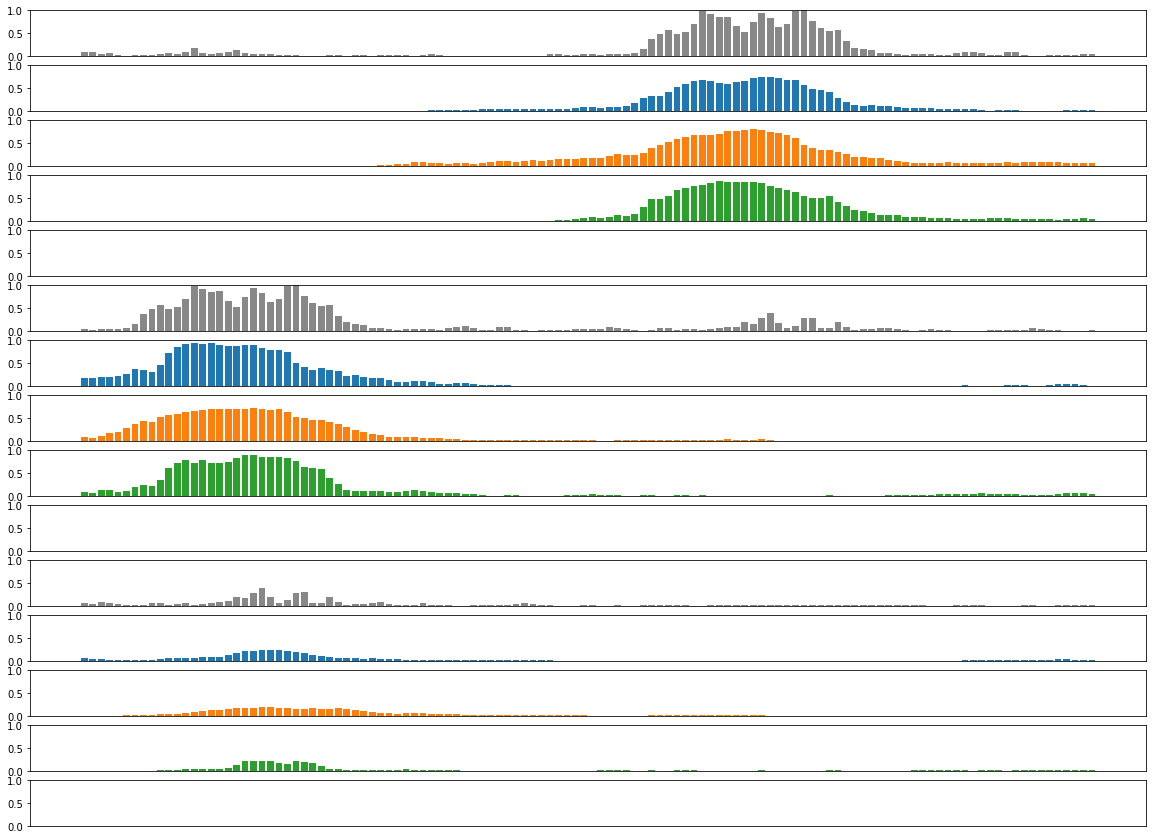

In [52]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')

n = 3
offset = 6337

ymax = 1.0

plt.figure(figsize=(20, n * (num_setups + 1)))
for i in range(n):
    k = i + offset
    
    # display original
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 1) + 1)
    ax.set_facecolor('#ffffff')
    plt.bar(np.arange(data_test_norm[k].size), data_test_norm[k], color='#888888')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
    
    for j in range(num_setups):
        # display reconstruction
        ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 1) + j + 2)
        plt.bar(np.arange(predicteds[j][k].size), predicteds[j][k], color=cmap(j))
        plt.ylim(0, ymax)
        ax.get_xaxis().set_visible(False)
plt.show()